# HW4 KAMENEV VLADIMIR

### Доступные колонки
##### date_time - время показа рекламы
##### oaid_hash - хэш юзера
##### zone_id - id зоны, где зона - место на сайте для размещения рекламы
##### banner_id - id баннера, где баннер - сама реклама
##### os_id - id операционной системы
##### country_id - id страны
##### banner_id0 - нулевой баннер в “стакане” баннеров
##### banner_id1 - перый баннер в “стакане” баннеров
##### rate0 - стоимость 1 клика установленная рекламодателем для banner_id0
##### rate1 - стоимость 1 клика установленная рекламодателем для banner_id1
##### g0 - стандартное отклонение предикта с banner_id0
##### g1 - стандартное отклонение предикта с banner_id1
##### coeff_sum0 - сумма коэффициентов для banner_id0
##### coeff_sum1 - сумма коэффициентов для banner_id1
##### impressions - был ли показ
##### clicks - был ли клик

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.model_selection import cross_validate

#### Готовим данные

In [2]:
data = pd.read_csv('../../../DATA/data.csv')
# data = data.sample(frac=0.001) # нужно для проверки пайплайна, в финале не используется
data['date_time'] = data['date_time'].apply(lambda x: datetime.strptime(x.split('.')[0],'%Y-%m-%d %H:%M:%S'))# для удобной работы со временем
data = data.sort_values(by=['date_time']) 

In [3]:
used_cols = ['date_time','oaid_hash','zone_id','banner_id','os_id','country_id','banner_id0','banner_id1','rate0','rate1','g0','g1',
'coeff_sum0','coeff_sum1','clicks']

#### Также выбрасываем аномалии и добавляем свои кастомные фичи

In [4]:
data = data[data['date_time'].dt.date != pd.Timestamp('2021-09-01').date()]

In [5]:
used_data = data[used_cols]

In [6]:
used_data = used_data.drop_duplicates()
used_data['month'] = used_data['date_time'].dt.month
used_data['day'] = used_data['date_time'].dt.day
used_data['hour'] = used_data['date_time'].dt.hour
used_data['is_day'] = used_data['hour'].apply(lambda x: 1 if int(x)>=12 and int(x) <=24 else 0) # Был ли показ днем
used_data['is_night'] = used_data['is_day'].apply(lambda x: 1 if x==0 else 0) # Был ли показ ночью
used_data['is_weekend'] = used_data['date_time'].apply(lambda x: 1 if x.weekday() > 4 else 0) # Был ли показ на выходных

In [7]:
used_data.head()

,date_time,oaid_hash,zone_id,banner_id,os_id,country_id,banner_id0,banner_id1,rate0,rate1,...,g1,coeff_sum0,coeff_sum1,clicks,month,day,hour,is_day,is_night,is_weekend
5041415,2021-09-26,1834033519797437404,41,29,3,0,29,6,0.002,0.002,...,0.020875,-4.736584,-4.898257,0,9,26,0,0,1,1
1442602,2021-09-26,7416450538971744701,1,188,2,15,188,11754925,0.008,0.330,...,0.012351,-3.811444,-2.106896,0,9,26,0,0,1,1
7232498,2021-09-26,1832228443297591417,17,52,2,5,52,41,0.008,0.004,...,0.067812,-4.317590,-3.739501,0,9,26,0,0,1,1
14938691,2021-09-26,4180077124914749282,47,73,4,13,73,1040,0.008,0.008,...,0.157515,-2.382508,-3.037939,0,9,26,0,0,1,1
11536774,2021-09-26,1459689388363839798,48,266,0,1,266,124,0.005,0.003,...,0.052319,-3.774143,-3.481748,0,9,26,0,0,1,1


In [8]:
feats = ['zone_id','banner_id','os_id','country_id','hour',
        'is_day','is_night','is_weekend']
target = 'clicks'

In [9]:
end_last_day = used_data['date_time'].iloc[-1]
start_last_day = end_last_day - pd.to_timedelta(1, unit='d')

In [10]:
train_data = used_data[(used_data['date_time']<start_last_day)]

In [11]:
test_data = used_data[(data['date_time']>start_last_day) & (data['date_time']<=end_last_day)]


/tmp/ipykernel_33194/1003397196.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test_data = used_data[(data['date_time']>start_last_day) & (data['date_time']<=end_last_day)]


#### Есть ли пустые значения в тесте:

In [12]:
display(test_data.isna().sum())
test_data.dropna(inplace=True) ### дропаем пустые строчки

date_time        0
oaid_hash        0
zone_id          0
banner_id        0
os_id            0
country_id       0
banner_id0       0
banner_id1       0
rate0           12
rate1         4904
g0              12
g1            4904
coeff_sum0      12
coeff_sum1    4904
clicks           0
month            0
day              0
hour             0
is_day           0
is_night         0
is_weekend       0
dtype: int64

/tmp/ipykernel_33194/3040313239.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.dropna(inplace=True) ### дропаем пустые строчки


#### Подгоняем тест под условие задачи (для pi_0 и pi_1)

In [13]:
data_test_pi0 = test_data[~test_data['banner_id'] != test_data['banner_id0']] # убираем ячейки, где banner_id не совпадает с banner_id0
data_test_pi1 = data_test_pi0.copy()
data_test_pi1['banner_id'] = data_test_pi1['banner_id1']

#### Готовим train/test

In [14]:
X_train = train_data[feats]
Y_train = train_data[target]

In [15]:
X_test_pi0 = data_test_pi0[feats]
X_test_pi1 = data_test_pi0[feats]
Y_test = data_test_pi0[target]

In [16]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse=True)
X_train = ohe.fit_transform(X_train)
X_test_pi0 = ohe.transform(X_test_pi0)
X_test_pi1 = ohe.transform(X_test_pi1)

/home/kotvkaskepc/anaconda3/envs/gpuenv/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [17]:
feature_selector = SelectKBest(chi2, k=1000)

In [18]:
X_train = feature_selector.fit_transform(X_train, Y_train)

In [19]:
X_test_pi0 = feature_selector.transform(X_test_pi0)
X_test_pi1 = feature_selector.transform(X_test_pi1)

##### Выберем лучшую модель при помощи кросс-валидации

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit,GridSearchCV

In [21]:
def create_model():
    return LogisticRegression(solver='liblinear', penalty='l2')

In [22]:
def cv(X_train,Y_train): ### Подбираем параметр C
    model = create_model()
    param_search = {'C' : [0.001, 0.01, 0.1, 1.]}

    splits = TimeSeriesSplit(n_splits=3)
    clf = GridSearchCV(estimator=model, cv=splits,
                            param_grid=param_search, verbose=10, scoring=['roc_auc', 'neg_log_loss'], refit="neg_log_loss")
    clf.fit(X_train, Y_train)
    
    return clf

In [23]:
%%time
best_model = cv(X_train,Y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3; 1/4] START C=0.001.....................................................
[CV 1/3; 1/4] END C=0.001; neg_log_loss: (test=-0.085) roc_auc: (test=0.681) total time=   6.6s
[CV 2/3; 1/4] START C=0.001.....................................................
[CV 2/3; 1/4] END C=0.001; neg_log_loss: (test=-0.113) roc_auc: (test=0.666) total time=  12.4s
[CV 3/3; 1/4] START C=0.001.....................................................
[CV 3/3; 1/4] END C=0.001; neg_log_loss: (test=-0.152) roc_auc: (test=0.754) total time=  25.9s
[CV 1/3; 2/4] START C=0.01......................................................
[CV 1/3; 2/4] END C=0.01; neg_log_loss: (test=-0.083) roc_auc: (test=0.704) total time=  10.6s
[CV 2/3; 2/4] START C=0.01......................................................
[CV 2/3; 2/4] END C=0.01; neg_log_loss: (test=-0.111) roc_auc: (test=0.698) total time=  26.5s
[CV 3/3; 2/4] START C=0.01...............................

In [24]:
from sklearn.metrics import log_loss,roc_auc_score, classification_report

In [25]:
prediction = best_model.predict_proba(X_test_pi0)[:,1]
print('LogReg Results: ')
print('Log Loss: ',log_loss(Y_test,prediction))
print('ROCAUC Score: ',roc_auc_score(Y_test,prediction))
print('Основные метрики: \n\n',classification_report(Y_test,prediction>0.5))

LogReg Results: 
Log Loss:  0.13286554865004138
ROCAUC Score:  0.7786163601907713
Основные метрики: 

               precision    recall  f1-score   support

           0       0.97      1.00      0.98   2048643
           1       0.57      0.00      0.00     74245

    accuracy                           0.97   2122888
   macro avg       0.77      0.50      0.49   2122888
weighted avg       0.95      0.97      0.95   2122888



#### Расчет CIPS

In [26]:
from scipy.special import logit
from scipy.stats import norm

In [27]:
coeff_sum0_new = logit(best_model.predict_proba(X_test_pi0)[:, 1]) 
coeff_sum1_new = logit(best_model.predict_proba(X_test_pi1)[:, 1])

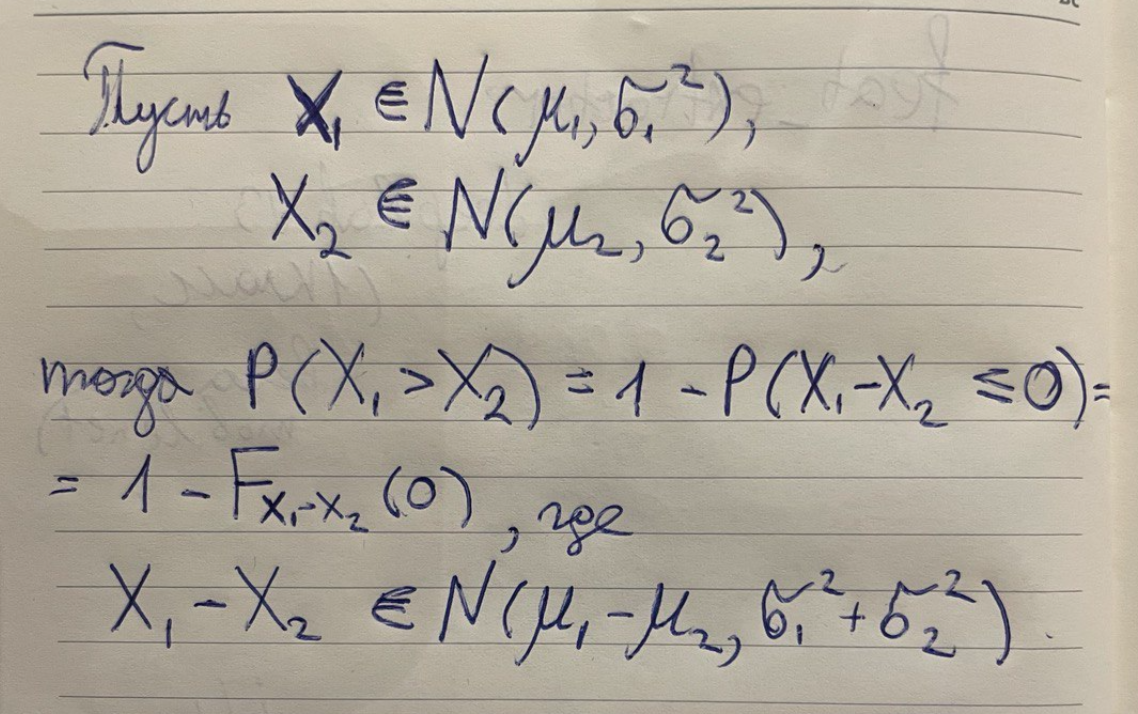

In [28]:
def banner_prob(mu1, sigma1, mu2, sigma2):
    return 1 - norm.cdf(0, loc=mu1-mu2, scale=np.sqrt(sigma1**2 + sigma2**2) + 1e-6)

In [29]:
pi0 = banner_prob(test_data['coeff_sum0'],test_data['g0'],
                  test_data['coeff_sum1'],
                  test_data['g1']) # сравнение нормальных величин

pi1 = banner_prob(coeff_sum0_new,test_data['g0'],
                  coeff_sum1_new,
                  test_data['g1'])# сравнение нормальных величин


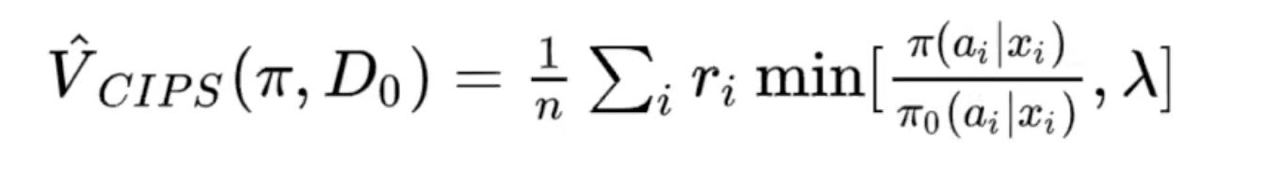

In [30]:
def cips(reward,pi0,pi1,lambda_val = 10):
    res = np.mean(reward*np.minimum(pi1/(pi0+1e-3),
                                     lambda_val))
    return res

In [31]:
cips(Y_test,pi0,pi1)

0.07744971844894125